💡 [`csr_matrix` information on indexing](https://stackoverflow.com/a/52299730) \
💡 [`scipy.sparse.coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy-sparse-coo-matrix) \
💡 [`scipy.sparse.csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy-sparse-csr-matrix) \
💡 [`scipy.sparse.lil_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix) \
💡 [`%%timeit` magic documentation](https://ipython.readthedocs.io/en/stable/interactive/magics.html) 

### 0. imports

In [54]:
# data science
import scipy as sp
import numpy as np
import pandas as pd
# random numbers https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
from numpy.random import default_rng
rng = default_rng()
# plotting
import matplotlib.pyplot as plt
# i/o
import gzip
import csv
import pickle
# type hints
from scipy.sparse import (
    coo_matrix,
    csr_matrix,
    csc_matrix,
    lil_matrix
)
from IPython.core.magics.execution import TimeitResult

### 1.1. generate matrices
#### 1.1.1. sample sparse matrix
⏳ runtime ~10s/20kx20k matrix

In [20]:
M_coo = sp.sparse.random(
    m = 20000,
    n = 20000,
    density = 0.01,
    format = 'coo',
    dtype = float,
    random_state = 42
)
M_csr = sp.sparse.random(
    m = 20000,
    n = 20000,
    density = 0.01,
    format = 'csr',
    dtype = float,
    random_state = 42
)
M_lil = sp.sparse.random(
    m = 20000,
    n = 20000,
    density = 0.01,
    format = 'lil',
    dtype = float,
    random_state = 42
)

### 1.1.2. ecoinvent

In [51]:
%%capture
print(path_file_e2m_pickle := './data/ecoinvent_3_5_cutoffPandas_symmNorm.gz.pickle')
print(path_file_e2m_rows_to_zero := './data/rows_to_zero.csv')

In [88]:
with gzip.open(path_file_e2m_pickle, 'rb') as file_in:
    ecoinvent: dict = pickle.load(file_in)
A = ecoinvent['A']
A_coo = sp.sparse.coo_matrix(A)
A_csr = sp.sparse.csr_matrix(A)
A_lil = sp.sparse.lil_matrix(A)

### 1.2. generate list of rows to set to zero
#### 1.2.1. sample sparse matrix
ℹ️ `index_M_zero` contains only indices of rows to be set to zero 

In [106]:
array_for_masking_M: np.array = rng.choice(
    a = [0, 1],
    size = (M_coo.shape[0], ),
    p = [0.2, 0.8]
)
index_M: np.array = np.arange(
    start = 0,
    stop = M_coo.shape[0],
    step = 1,
    dtype=int
)
index_M_zero: np.array = np.ma.masked_array(
    data = index_M,
    mask = array_for_masking_M
).compressed()

#### 1.2.2. ecoinvent

In [105]:
array_for_masking_A: np.array = rng.choice(
    a = [0, 1],
    size = (A_coo.shape[0], ),
    p = [0.45, 0.55]
)
index_A: np.array = np.arange(
    start = 0,
    stop = A_coo.shape[0],
    step = 1,
    dtype=int
)
index_A_zero: np.array = np.ma.masked_array(
    data = index_A,
    mask = array_for_masking_A
).compressed()

### 2.1. implementations of "set rows to zero"
#### 2.1.1. ["COO: multiply with a diagonal matrix"](https://stackoverflow.com/a/65364784)

In [23]:
def matrix_multiplication(
    matrix: coo_matrix,
    rows: np.array
) -> coo_matrix:

    array_for_diagonal: np.array = np.ones(
        shape = [matrix.shape[0]],
        dtype = int
    )
    array_for_diagonal[rows] = 0

    matrix = matrix @ sp.sparse.diags(array_for_diagonal)

    return matrix


#### 2.1.2 ["CSR: edit `csr.data` using a for-loop with `csr.indptr`"](https://stackoverflow.com/q/12129948)

💡 [`csr_matrix` information on indexing](https://stackoverflow.com/a/52299730)

In [24]:
def csr_loop_set_rows_to_zero(
    matrix: csr_matrix,
    rows: np.array
) -> csr_matrix:

    for row in rows:
        matrix.data[
            matrix.indptr[row]:matrix.indptr[row+1]
        ] = 0
        
    return matrix

#### 2.1.3 ["CSR: regular indexing notation"](https://stackoverflow.com/a/15900629)

⚠️ this runs too long for `%%timeit` to complete in a reasonable time

In [25]:
def csr_indexing_set_rows_to_zero(
    matrix: csr_matrix,
    rows: np.array
) -> csr_matrix:

    for row in rows:
        matrix[row,:] = 0
    
    return matrix

#### 2.1.4 ["LIL: regular indexing notation"](https://stackoverflow.com/a/69310639)

💡 [`scipy.sparse.lil_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix)

In [26]:
def lil_set_rows_to_zero(
    matrix: lil_matrix,
    rows: np.array
) -> lil_matrix:

    for row in rows:
        matrix[row,:] = 0
    
    return matrix

#### 2.1.5 "CSR/dense: convert back-and-forth between dense and sparse matrices"

In [27]:
def convert_to_dense_and_back(
    matrix: coo_matrix,
    rows: np.array
) -> coo_matrix:

    mask_rows = np.ones(
        shape = (matrix.shape[0], ),
        dtype = bool
    )
    mask_rows[rows] = False

    matrix_dense = matrix.todense()
    matrix_dense[mask_rows] = 0
    matrix = coo_matrix(matrix_dense)

    return matrix


#### 2.1.6 ["CSR: mask out `csr.data` and `csr.indices` using `csr.indptr`"](https://stackoverflow.com/a/19800305)

❓ what does `np.diff(csr_matrix.indptr)` do? \
❗️ it counts the number of `data` per *index pointer* (`indptr`), which is the number of `data` per *row*

❓ what does `np.repeat(mask, nnz_per_row)` do? \
❗️ see OneNote drawing

In [44]:
def csr_mask_set_rows_to_zero(
    matrix: csr_matrix,
    rows: np.array
) -> csr_matrix:

    number_nonzero_per_row: np.array = np.diff(matrix.indptr)

    mask_rows = np.ones(
        shape = (matrix.shape[0], ),
        dtype = bool
    )
    mask_rows[rows] = False

    mask = np.repeat(
        a = mask_rows, # input array, TRUE for rows to keep, FALSE for rows to set 0
        repeats = number_nonzero_per_row # array with number of non-zero elements (=data) per row
    )
 
    number_nonzero_per_row[rows] = 0

    matrix.data = matrix.data[mask]
    matrix.indices = matrix.indices[mask]
    matrix.indptr[1:] = np.cumsum(number_nonzero_per_row)

    return matrix

#### 2.1.7 ["CSR: concatenate magic"](https://stackoverflow.com/a/58748646)

🙈 whaaat?

In [29]:
def qq():
    idx = a.indptr.searchsorted(*(a.indices==i).nonzero(),"right")-1
    return np.bincount(
        np.concatenate([a.indices[a.indptr[i]:a.indptr[i+1]] for i in idx]),
        np.concatenate([a.data[a.indptr[i]:a.indptr[i+1]] for i in idx]),
        a.shape[1]) / len(idx)

#### 2.1.8 [`pylcaio` implementation (convert to `pd.DataFrame`)](https://github.com/OASES-project/pylcaio/blob/master/src/pylcaio.py#L1340)

In [41]:
def pylcaio_implementation(
    matrix: csr_matrix,
    rows: np.array
) -> np.array:

    dataframe = pd.DataFrame(
        data = matrix.todense()
    )
    
    dataframe.loc[rows] = 0

    matrix = sp.sparse.csr_matrix(dataframe)

    return matrix

### 3.1. measuring performance
#### 3.1.1. sample sparse matrix

In [42]:
M_time_pylcaio: TimeitResult =  %timeit -o pylcaio_implementation(M_csr, index_M_zero)

2.29 s ± 5.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
M_time_conversion: TimeitResult = %timeit -o convert_to_dense_and_back(M_coo, index_M_zero)

2.22 s ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
M_time_lil: TimeitResult =  %timeit -o lil_set_rows_to_zero(M_lil, index_M_zero)

1.37 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
M_time_coo: TimeitResult = %timeit -o matrix_multiplication(M_coo, index_M_zero)

175 ms ± 472 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
M_time_csr_mask: TimeitResult = %timeit -o csr_mask_set_rows_to_zero(M_csr, index_M_zero)

11.2 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
M_time_csr_loop: TimeitResult =  %timeit -o csr_loop_set_rows_to_zero(M_csr, index_M_zero)

1.98 ms ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 3.1.2. ecoinvent technology matrix

In [107]:
A_time_pylcaio: TimeitResult =  %timeit -o pylcaio_implementation(A_csr, index_A_zero)

1.47 s ± 7.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
A_time_conversion: TimeitResult = %timeit -o convert_to_dense_and_back(A_coo, index_A_zero)

1.39 s ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
A_time_csr_loop: TimeitResult =  %timeit -o csr_loop_set_rows_to_zero(A_csr, index_A_zero)

3.46 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [110]:
A_time_coo: TimeitResult = %timeit -o matrix_multiplication(A_coo, index_A_zero)

2.67 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
A_time_csr_mask: TimeitResult = %timeit -o csr_mask_set_rows_to_zero(A_csr, index_A_zero)

357 µs ± 4.88 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [112]:
A_time_csr_loop: TimeitResult =  %timeit -o csr_loop_set_rows_to_zero(A_csr, index_A_zero)

3.37 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 3.2. plotting

Text(0, 0.5, 'runtime [s]')

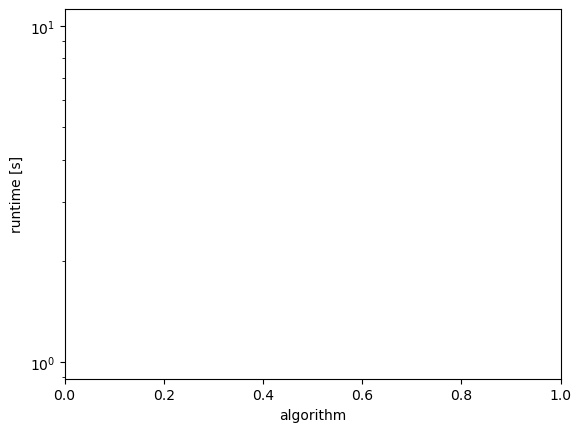

In [49]:
fig, ax = plt.subplots()

# axis scale
ax.set_yscale('log')

# axis labels
ax.set_xlabel('algorithm')
ax.set_ylabel('runtime [s]')